# Notebook 4: Axis Reductions — Column-Wise Statistics

## Introduction

This notebook demonstrates **axis operations** for computing column-wise statistics on 2D data.

**Key question**: When you have data organized as a matrix (e.g., stocks × days, sensors × time, features × samples), how do you efficiently compute statistics **per column** or **per row**?

We'll use daily stock prices for 10 tech stocks over 50 trading days.

---

## Use Case: Portfolio Analytics

Imagine a stock portfolio with 10 tech stocks:
- **50 days** of daily closing prices
- Need to compute:
  1. **Per-day statistics** (across all stocks): daily portfolio value, volatility
  2. **Per-stock statistics** (across all days): average price, median price, volatility

HPCSeries provides **axis operations** to efficiently handle this.

---

## Setup

Import HPCSeries and load the financial market data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hpcs
import time

# Display library info
print(f"HPCSeries version: {hpcs.__version__}")
print(f"SIMD ISA: {hpcs.simd_info()['isa']}")
print()

HPCSeries version: 0.7.0
SIMD ISA: AVX2

=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T


[SIMD] Registered OpenMP SIMD reduction kernels
[SIMD] Registered OpenMP SIMD rolling operations
[SIMD] Z-score kernels initialized
[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


## Load Data

Load stock price data for 10 tech stocks over 50 trading days.

In [2]:
# Load financial market data
df = pd.read_csv('data/financial_market_data.csv')
df['date'] = pd.to_datetime(df['date'])

# Extract stock columns as 2D NumPy array (days x stocks)
stock_cols = [col for col in df.columns if col != 'date']
prices = df[stock_cols].values

n_days, n_stocks = prices.shape

print(f"Dataset: {n_stocks} stocks, {n_days} trading days")
print(f"Shape: {prices.shape} (days x stocks)")
print(f"Stock tickers: {stock_cols}")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")
print()

# Show first few rows
df.head()

Dataset: 10 stocks, 50 trading days
Shape: (50, 10) (days x stocks)
Stock tickers: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'NVDA', 'AMD', 'INTC', 'NFLX']
Price range: $47.70 - $664.50



,date,AAPL,GOOGL,MSFT,AMZN,TSLA,META,NVDA,AMD,INTC,NFLX
0,2024-01-01,175.2,142.3,380.5,148.7,248.3,378.2,495.1,143.7,48.2,468.3
1,2024-01-02,176.8,143.1,382.7,149.5,251.2,380.5,498.7,145.2,48.9,472.1
2,2024-01-03,174.5,141.8,379.2,147.9,246.8,376.9,492.3,142.8,47.7,465.8
3,2024-01-04,177.3,144.2,384.1,150.8,253.7,382.3,502.5,146.9,49.5,475.9
4,2024-01-05,179.1,145.8,387.3,152.3,257.2,385.7,508.2,149.3,50.2,481.5


## Visualize Stock Prices

Plot all 10 stock price time-series.

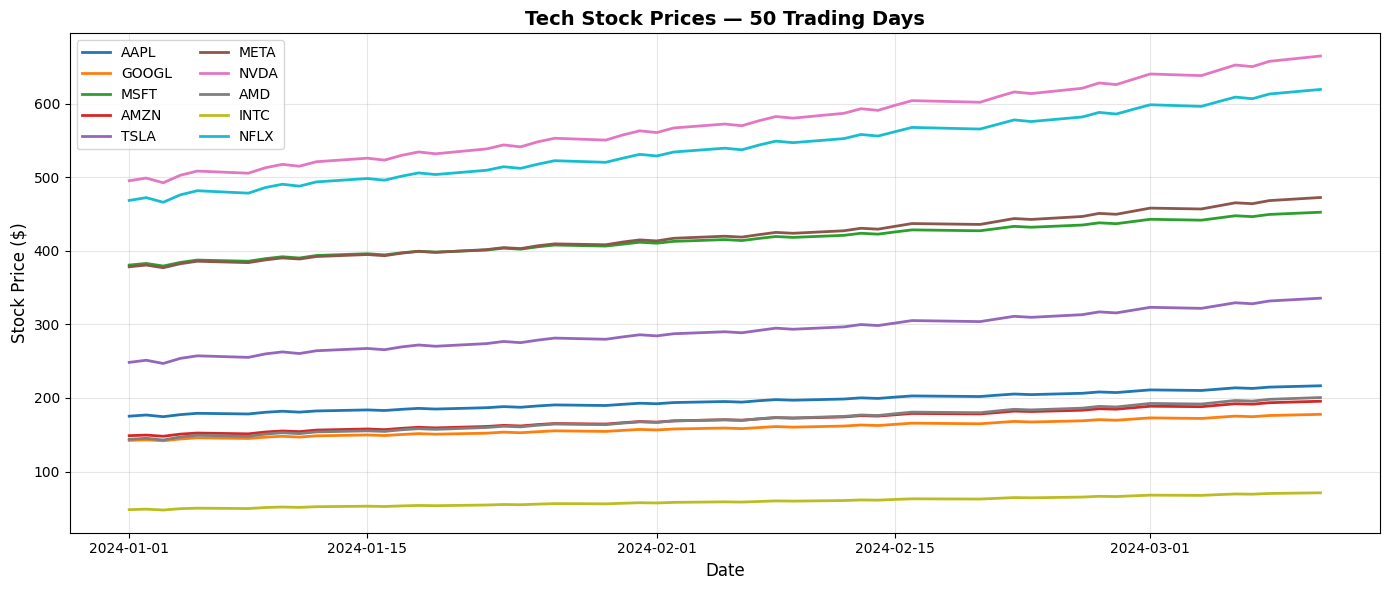

In [3]:
plt.figure(figsize=(14, 6))

for i, col in enumerate(stock_cols):
    plt.plot(df['date'], df[col], linewidth=2, label=col)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title('Tech Stock Prices — 50 Trading Days', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', ncol=2, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Axis Operation 1: Per-Day Portfolio Statistics

Compute statistics **across all stocks** for each day.

**Question**: What was the average portfolio value each day?

In [4]:
# Convert to Fortran-order (column-major) for efficient axis operations
prices_f = np.asfortranarray(prices)

# Compute per-day mean across all stocks (axis=1 reduces across columns)
daily_mean = hpcs.axis_mean(prices_f, axis=1)

print(f"Per-Day Portfolio Statistics (across {n_stocks} stocks):")
print("=" * 60)
print(f"Shape of daily_mean: {daily_mean.shape}")
print(f"Average portfolio value on Day 1: ${daily_mean[0]:.2f}")
print(f"Average portfolio value on Day {n_days}: ${daily_mean[-1]:.2f}")
print(f"Overall mean: ${hpcs.mean(daily_mean):.2f}")
print()

Per-Day Portfolio Statistics (across 10 stocks):
Shape of daily_mean: (50,)
Average portfolio value on Day 1: $262.85
Average portfolio value on Day 50: $340.50
Overall mean: $298.54

=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T


[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


## Visualize Daily Portfolio Value

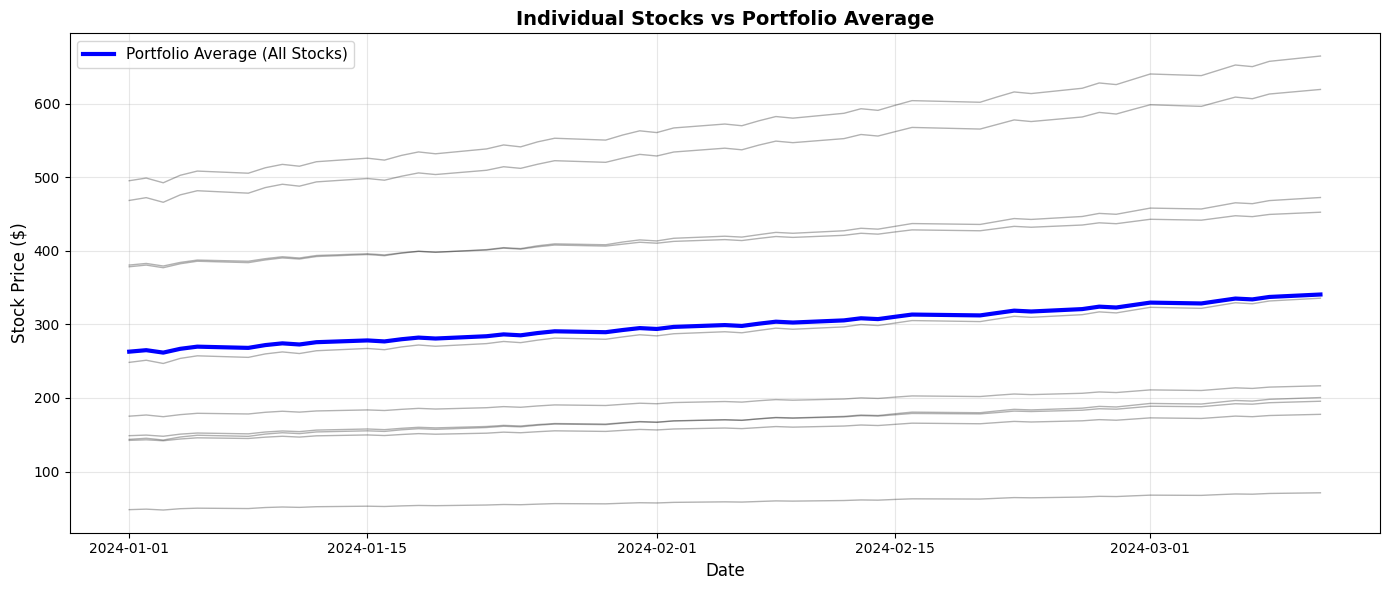

In [6]:
plt.figure(figsize=(14, 6))

# Plot all individual stocks (faint)
for i, col in enumerate(stock_cols):
    plt.plot(df['date'], prices[:, i], alpha=0.3, linewidth=1.0, color='black')

# Plot daily portfolio average (bold)
plt.plot(df['date'], daily_mean, linewidth=3, color='blue', label='Portfolio Average (All Stocks)')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title('Individual Stocks vs Portfolio Average', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Axis Operation 2: Per-Day Sum (Total Portfolio Value)

If you own 1 share of each stock, what's the total portfolio value each day?

In [7]:
# Compute per-day sum across all stocks
daily_sum = hpcs.axis_sum(prices_f, axis=1)

print(f"Total Portfolio Value (1 share of each stock):")
print("=" * 60)
print(f"Day 1 total value: ${daily_sum[0]:.2f}")
print(f"Day {n_days} total value: ${daily_sum[-1]:.2f}")
print(f"Portfolio growth: ${daily_sum[-1] - daily_sum[0]:.2f} ({(daily_sum[-1]/daily_sum[0] - 1)*100:.2f}%)")
print()

Total Portfolio Value (1 share of each stock):
Day 1 total value: $2628.50
Day 50 total value: $3405.00
Portfolio growth: $776.50 (29.54%)



## Visualize Portfolio Growth

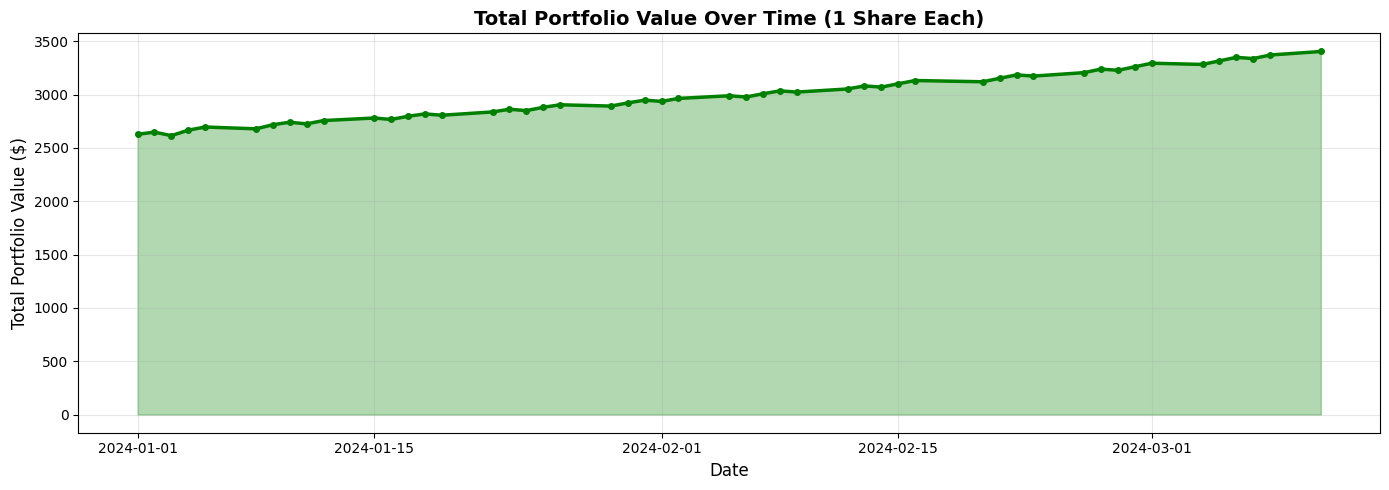

In [8]:
plt.figure(figsize=(14, 5))

plt.plot(df['date'], daily_sum, linewidth=2.5, color='green', marker='o', markersize=4)
plt.fill_between(df['date'], daily_sum, alpha=0.3, color='green')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Portfolio Value ($)', fontsize=12)
plt.title('Total Portfolio Value Over Time (1 Share Each)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Axis Operation 3: Per-Stock Statistics

Now compute statistics **per stock across all days**.

To operate on **columns** instead of rows, we transpose the data.

In [9]:
# Transpose to (stocks x days) and convert to Fortran-order
prices_T = np.asfortranarray(prices.T)

# Compute per-stock statistics
stock_mean = hpcs.axis_mean(prices_T, axis=1)      # Mean price per stock
stock_median = hpcs.axis_median(prices_T, axis=1)  # Median price per stock
stock_mad = hpcs.axis_mad(prices_T, axis=1)        # MAD per stock (volatility measure)

# Create summary table
stock_stats = pd.DataFrame({
    'ticker': stock_cols,
    'mean_price': stock_mean,
    'median_price': stock_median,
    'mad': stock_mad,
    'volatility_pct': (stock_mad / stock_median) * 100
}).sort_values('mean_price', ascending=False)

print("Per-Stock Summary Statistics:")
print("=" * 70)
print(stock_stats.to_string(index=False))
print()

Per-Stock Summary Statistics:
ticker  mean_price  median_price   mad  volatility_pct
  NVDA     571.606        568.30 41.60        7.320077
  NFLX     538.206        535.60 36.70        6.852128
  META     419.786        417.70 22.45        5.374671
  MSFT     414.346        413.25 17.10        4.137931
  TSLA     289.176        287.85 20.05        6.965433
  AAPL     194.570        194.00 10.00        5.154639
   AMD     170.104        169.10 13.50        7.983442
  AMZN     170.040        169.30 11.15        6.585942
 GOOGL     158.760        158.05  8.40        5.314774
  INTC      58.758         58.30  5.35        9.176672



## Visualize Per-Stock Statistics

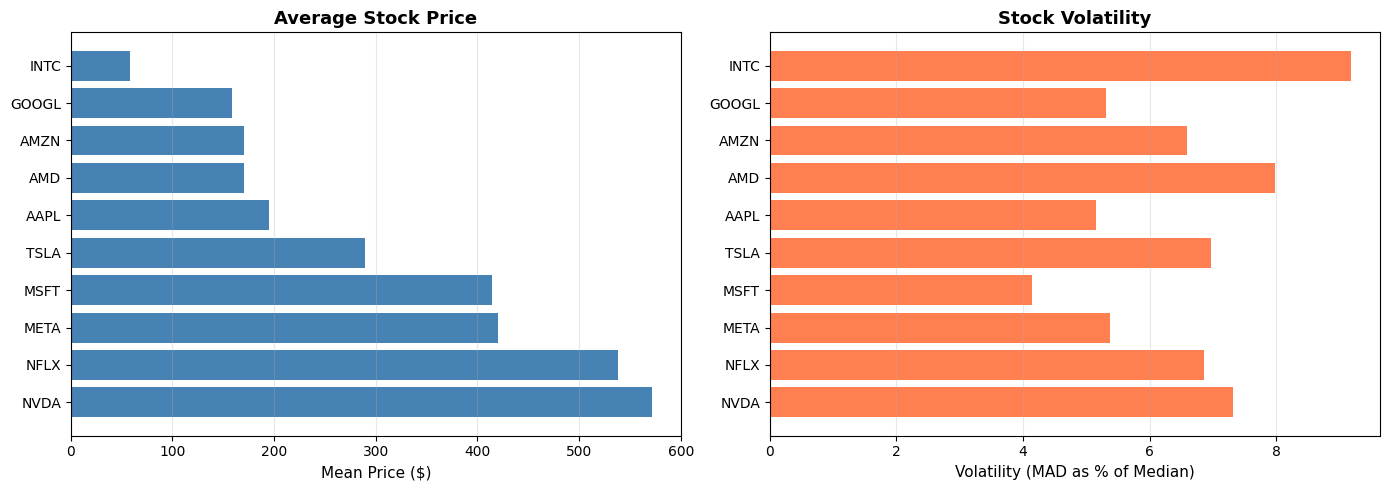

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean price per stock
axes[0].barh(stock_stats['ticker'], stock_stats['mean_price'], color='steelblue')
axes[0].set_xlabel('Mean Price ($)', fontsize=11)
axes[0].set_title('Average Stock Price', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Volatility per stock (MAD as % of median)
axes[1].barh(stock_stats['ticker'], stock_stats['volatility_pct'], color='coral')
axes[1].set_xlabel('Volatility (MAD as % of Median)', fontsize=11)
axes[1].set_title('Stock Volatility', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Use Case: Risk Assessment

Identify **low-risk** (stable) vs **high-risk** (volatile) stocks using MAD.

In [11]:
# Sort by volatility
stock_by_volatility = stock_stats.sort_values('volatility_pct')

print("Stock Risk Assessment:")
print("=" * 70)
print()
print("🟢 LOW RISK (Most Stable):")
for i, row in stock_by_volatility.head(3).iterrows():
    print(f"  {row['ticker']:6s} — Volatility: {row['volatility_pct']:.2f}% (Median: ${row['median_price']:.2f})")
print()
print("🔴 HIGH RISK (Most Volatile):")
for i, row in stock_by_volatility.tail(3).iterrows():
    print(f"  {row['ticker']:6s} — Volatility: {row['volatility_pct']:.2f}% (Median: ${row['median_price']:.2f})")

Stock Risk Assessment:

🟢 LOW RISK (Most Stable):
  MSFT   — Volatility: 4.14% (Median: $413.25)
  AAPL   — Volatility: 5.15% (Median: $194.00)
  GOOGL  — Volatility: 5.31% (Median: $158.05)

🔴 HIGH RISK (Most Volatile):
  NVDA   — Volatility: 7.32% (Median: $568.30)
  AMD    — Volatility: 7.98% (Median: $169.10)
  INTC   — Volatility: 9.18% (Median: $58.30)


## Performance Benchmark: Scaling to Large Datasets

Test axis operations on a large dataset (1000 stocks × 10,000 days).

In [ ]:
# Create large synthetic dataset
n_stocks_large = 1000
n_days_large = 10_000

print(f"Benchmark: {n_stocks_large} stocks, {n_days_large} days")
print(f"Total data points: {n_stocks_large * n_days_large:,}")
print()

large_prices = np.random.randn(n_days_large, n_stocks_large) * 50 + 200
large_prices_f = np.asfortranarray(large_prices)

# Benchmark: axis_mean (per-day average)
print("Task 1: Compute per-day average (axis_mean)")
start = time.perf_counter()
_ = hpcs.axis_mean(large_prices_f, axis=1)
elapsed = time.perf_counter() - start
print(f"  Time: {elapsed*1000:.2f} ms")
print(f"  Throughput: {n_stocks_large * n_days_large / elapsed / 1e6:.1f} M values/sec")
print()

# Benchmark: axis_median (per-day median)
print("Task 2: Compute per-day median (axis_median)")
start = time.perf_counter()
_ = hpcs.axis_median(large_prices_f, axis=1)
elapsed = time.perf_counter() - start
print(f"  Time: {elapsed*1000:.2f} ms")
print(f"  Throughput: {n_stocks_large * n_days_large / elapsed / 1e6:.1f} M values/sec")
print()

# Benchmark: axis_mad (per-day MAD)
print("Task 3: Compute per-day MAD (axis_mad)")
start = time.perf_counter()
_ = hpcs.axis_mad(large_prices_f, axis=1)
elapsed = time.perf_counter() - start
print(f"  Time: {elapsed*1000:.2f} ms")
print(f"  Throughput: {n_stocks_large * n_days_large / elapsed / 1e6:.1f} M values/sec")
print()

print(f"✓ HPCSeries efficiently handles {n_stocks_large} stocks with {n_days_large:,} days!")

Benchmark: 1000 stocks, 10000 days
Total data points: 10,000,000



## What We Learned

### Key Takeaways:

1. **Axis operations** efficiently compute statistics along matrix rows or columns.
   - `axis=1` reduces across columns (per-row statistics)
   - Transpose for per-column statistics

2. **Fortran-order arrays** are critical for optimal axis operation performance.
   - Use `np.asfortranarray()` before calling axis functions.

3. **Robust statistics** (median, MAD) are ideal for financial data.
   - MAD measures volatility without being distorted by extreme events.

4. **HPCSeries scales** to large datasets (1000s of stocks, 10,000s of days).
   - SIMD acceleration and efficient algorithms handle big matrices.

### HPCSeries Functions Used:

- `hpcs.axis_sum()` — Total portfolio value per day
- `hpcs.axis_mean()` — Average portfolio value per day
- `hpcs.axis_median()` — Robust average per stock
- `hpcs.axis_mad()` — Volatility measure per stock

### Common Use Cases:

| Domain | Use Case | HPCSeries Approach |
|--------|----------|--------------------|
| **Finance** | Portfolio analytics | axis_sum, axis_mean for daily values |
| **Finance** | Risk assessment | axis_mad for volatility |
| **ML/AI** | Feature statistics | axis_mean, axis_median per feature |
| **Climate** | Spatial averaging | axis_mean across stations |
| **Manufacturing** | Quality control | axis_median, axis_mad per batch |

---

## Next Steps

See the next notebook:
- **Notebook 5**: Masked analytics for handling missing data with `hpcs.mean_masked()`, `hpcs.median_masked()`
